In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dask.distributed import Client
from distributed.deploy.local import LocalCluster
from pycalphad import Database, equilibrium, variables as v
#from pduq.invariant_calc import invariant_samples
from pduq.uq_plot import plot_contour
sns.set(color_codes=True)
c = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(c)
print(client)
import logging
import pickle
import sympy
import numpy as np
import xarray as xr
from collections import OrderedDict
from espei.utils import database_symbols_to_fit
from itertools import chain
from pycalphad import equilibrium, variables as v
from pycalphad.codegen.callables import build_callables
from pycalphad.core.utils import instantiate_models
from time import time
import logging
import numpy as np
#from .dbf_calc import eq_calc_  # , get_eq_callables_
from espei.utils import database_symbols_to_fit
from pycalphad import variables as v
dbf = Database('co-cu_dft.tdb')
params = np.load('trace.npy')[:, -1, :]
X = 0.93  # X_MG guess for invariant
P = 101324  # pressure
Tl = 1350  # lower temperature bound for invariant
Tu = 1450  # upper temperature bound for invariant
comp = 'CU' # species to reference for composition

<Client: 'tcp://127.0.0.1:52515' processes=8 threads=8, memory=31.77 GiB>


In [2]:
def eq_calc_(dbf, comps, phases, conds,
             paramA, symbols_to_fit,
             eq_callables=None):

    param_dict = {param_name: param for param_name, param
                  in zip(symbols_to_fit, paramA)}

    parameters = OrderedDict(sorted(param_dict.items(), key=str))

    eq_result = equilibrium(dbf, comps, phases, conds,
                            parameters=parameters, callables=eq_callables)
    return eq_result

In [3]:
def invariant_(index, dbf, params, comps, phases, X, P, Tl, Tu, comp,
               symbols_to_fit, eq_callables):
    #print("Entering invariant_")
    kwargs = {'dbf': dbf, 'comps': comps, 'phases': phases,
              'paramA': params[index, :], 'symbols_to_fit': symbols_to_fit,
              'eq_callables': eq_callables}

    def mini(T):
        #print("Running mini function")
        """
        perform the equilibrium calculation at a specified temperature
        and return the list of unique phases in equilibrium along with the
        equlibrium data object
        """
        conds = {v.P: P, v.T: T, v.X(comp): X}
        eq = eq_calc_(conds=conds, **kwargs)
        #print(f"mini eq Temperature: {eq.T.values}, Phases result: {eq.Phase.values}, Composition result: {eq.X.values}")
        #PhT = list(np.unique(eq.Phase))
        #PhT = eq.Phase.values.tolist()  # 将 xarray 对象转换为普通列表
        PhT = list(eq.Phase.values.flatten())  # 保留所有相位，即使有重复zhanghaihui
        #print(f"mini Temperature: {T}, Phases found: {PhT}")  # Debug output
        if '' in PhT:
            PhT.remove('')
            #print(f"mini Temperature: {T}, Phases found2: {PhT}")  # Debug output
        return eq, PhT
        

    # perform equilibrium calculations at the lower bound, middle, and
    # upper bound temperatures
    Tm = 0.5*(Tl+Tu)  # middle temperature
    eql, PhTl = mini(Tl)
    eqm, PhTm = mini(Tm)
    equ, PhTu = mini(Tu)

    # now we use the bisection method to find the invariant temperature
    # and composition

    # identify the number of calculations so that the error in the
    # temperature is less than errlim
    errlim = 0.01
    niter = np.log(errlim/(Tu-Tl))/np.log(0.5) - 1
    niter = np.int16(np.ceil(niter))

    for ii in range(niter):
        # if the phases in equilibrium at the middle temperature are
        # different than at the lower temperature, then the invariant
        # will be between the lower and middle temperature. We can then
        # set the upper temperature to the previous middle temperature.
        # Otherwise, the invariant will be between the middle and upper
        # temperature.
        if str(PhTm) != str(PhTl):
            Tu = Tm
            equ = eqm
            PhTu = PhTm
        else:
            Tl = Tm
            eql = eqm
            PhTl = PhTm
        Tm = 0.5*(Tl + Tu)  # get the new middle temperature
        eqm, PhTm = mini(Tm)  # calculate the Tm equilibrium
        # print(Tm, ' ', PhTm)

    def getbnd(eq, PhT):
        #print("Running getbnd function")
        #print(f"getbnd Phases found: {PhT}")  # Debug output
        """
        get the molar compositions of the phases in PhT
        """
        bnd = []
        for phase in PhT:
            tmp = eq.X.where(eq.Phase == phase)
            tmp = tmp.sel(component=comp).sum(dim='vertex')
            bnd.append(np.squeeze(tmp.values))
           # print(f"getbnd bnd: {bnd}")  # Debug output
        return np.array(bnd)
   # print(f"xxxxxxinvariant_ PhTl: {PhTl}")  # Debug output
   # print(f"xxxxxxinvariant_ PhTu: {PhTu}")  # Debug output
    # PhTA are the phases at Tl and Tu
    PhTA = np.concatenate([PhTl, PhTu])
    # bndA are the molar compositions of the phases in PhTl and PhTu
    bndA = np.concatenate([getbnd(eql, PhTl), getbnd(equ, PhTu)])
    # phs are the unique phases in the three phase region
    # 先去除空字符串
    PhTA_filtered = [p for p in PhTA if p != '']
    # 然后再使用 np.unique
    phs, indx = np.unique(PhTA_filtered, return_index=True)
    #phs, indx = np.unique(PhTA, return_index=True)
    # bnd are the molar compositions corresponding to phs
    bnd = bndA[indx]
    #print(f"xxxxxxinvariant_ PhTA: {PhTA}")  # Debug output
   # print(f"xxxxxxinvariant_ phs1: {phs}")  # Debug output
   # print(f"xxxxxxinvariant_ indx: {indx}")  # Debug output
   # print(f"xxxxxxinvariant_ bndA: {bndA}")  # Debug output
    #print(f"xxxxxxinvariant_ bnd1: {bnd}")  # Debug output

    indx = np.argsort(bnd)
    phs = list(phs[indx])
    bnd = bnd[indx]
   # print(f"xxxxxxinvariant_ indx2: {indx}")  # Debug output
   # print(f"xxxxxxinvariant_ phs2: {phs}")  # Debug output
   # print(f"xxxxxxinvariant_ bnd2: {bnd}")  # Debug output

    logging.info('Invariant computed for set ' + str(index))
    logging.info('T = ' + str(Tm) + ' +/- ' + str(Tm-Tl) + 'K')
    logging.info(str(phs))
    logging.info(str(bnd))

    # print('Invariant computed for set ', index)
    # print('T=', Tm, '+/-', Tm-Tl, 'K')
    #print(phs)
    # print(bnd)
    return Tm, phs, bnd, index

In [4]:
def invariant_samples(
        dbf, params, X, P, Tl, Tu, comp,
        client=None, comps=None, phases=None):
   # print("Entering invariant_samples")
#print(f"Params: {params}, X: {X}, P: {P}, Tl: {Tl}, Tu: {Tu}, comp: {comp}")
    if comps is None:
        comps = list(dbf.elements)

    if phases is None:
        phases = list(dbf.phases.keys())

    neq = params.shape[0]  # calculate invariants for neq parameter sets

    symbols_to_fit = database_symbols_to_fit(dbf)

    # eq_callables = get_eq_callables_(dbf, comps, phases, symbols_to_fit)
    eq_callables = None  # eq_callables is disabled for current pycalcphad

    kwargs = {'dbf': dbf, 'comps': comps, 'phases': phases,
              'X': X, 'P': P, 'Tl': Tl, 'Tu': Tu, 'comp': comp,
              'params': params, 'symbols_to_fit': symbols_to_fit,
              'eq_callables': eq_callables}

    # invariant_(0, **kwargs)

    # define the map for the invariant calculation for neq parameter sets
    if client is None:
        invL = []
        for ii in range(neq):
            #print("Running 111")
            inv_result = invariant_(ii, **kwargs)  # 确保参数正确
            invL.append(inv_result)
    else:
        #print("Running 222")
        A = client.map(invariant_, range(neq), **kwargs)
        invL = client.gather(A)
        client.close()
    print(invL[2][0])
    # collect the key results after the map
    Tv = np.zeros((neq,))
    phv = neq*[None]
    #bndv = np.zeros((neq, 3))
    max_phases = max([len(inv[1]) for inv in invL])  # dynamically find the maximum number of phases zhanghaihui
    bndv = np.zeros((neq, max_phases))  # Adjust dimensions based on the number of phases zhanghaihui
    for ii in range(neq):
        Tv[ii] = invL[ii][0]
        phv[ii] = invL[ii][1]
        #bndv[ii, :] = invL[ii][2]
        for j in range(len(invL[ii][2])):
            bndv[ii, j] = invL[ii][2][j]

    
    return Tv, phv, bndv
    #return Tv_filtered, phv_filtered, bndv_filtered

In [5]:
import time
# 记录开始时间
start_time = time.time()

# 调用函数
Tv, phv, bndv = invariant_samples(
    dbf, params, X, P, Tl, Tu, comp, client=None
)

# 记录结束时间
end_time = time.time()

# 计算并输出运行时间
elapsed_time = end_time - start_time
print(f"运行时间: {elapsed_time:.2f} 秒")

1392.767333984375
运行时间: 85.99 秒


In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FormatStrFormatter

def plot_kde_clusters(points, num_clusters=2, xlabel=r'$\mathrm{X_{Cu}}$', ylabel='T (K)', 
                      save_name='kde_cluster', text_offset=(0, 0), expt_points_list=None):
    """
    绘制KMeans聚类后每个聚类的KDE图，并显示外部的实验/计算数据点。
    
    参数:
    points: np.array, 点集，形状为 (n, 2)，包含bndv和Tv的值
    num_clusters: int, 聚类数量
    xlabel: str, 横坐标标签
    ylabel: str, 纵坐标标签
    expt_points_list: list of lists, 每个聚类的实验点, 例如 [expt_points1, expt_points2, ...]
                      expt_points: list of dicts, 每个dict包含x, y, label, color, marker
                      示例: [{'x': 0.399, 'y': 1053, 'label': 'Expt., Hansen et al.', 'color': 'blue', 'marker': 'o'}, ...]
    """
   
    # 只对聚类过程进行标准化
    scaler = StandardScaler()
    points_scaled = scaler.fit_transform(points)

    # 使用 KMeans 进行聚类
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    labels = kmeans.fit_predict(points_scaled)

    # 设置字体为 Times New Roman
    plt.rc('font', family='Times New Roman', size=16)
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'Times New Roman'

    # 创建调色板，用于不同聚类的 KDE 图
    color_palettes = sns.color_palette("Blues", num_clusters)

    # 循环绘制每个聚类的 KDE 图
    for i in range(num_clusters):
        # 根据聚类结果分组，使用原始数据进行绘图
        bndv_cluster = points[labels == i]  # 使用原始数据
        Tv_cluster = points[labels == i, 1]

        # 计算每个聚类的平均点
        mean_bndv = np.mean(bndv_cluster, axis=0)
        mean_Tv = np.mean(Tv_cluster)

        # 绘制聚类的 KDE 图
        plt.figure(figsize=(5, 3))
        sns.kdeplot(x=bndv_cluster[:, 0], y=Tv_cluster, fill=True, cmap="Blues")
        plt.scatter(bndv_cluster[:, 0], Tv_cluster, color='k', label=f'Invariant samples', s=5)
        plt.scatter(mean_bndv[0], mean_Tv, color='red', marker='o', label=f'Mean invariant', s=50)
        
        # 添加注释文本
        x_offset, y_offset = text_offset
        plt.annotate(f'({mean_bndv[0]:.3f}, {mean_Tv:.0f})', 
                     xy=(mean_bndv[0], mean_Tv), 
                     xytext=(mean_bndv[0] + x_offset, mean_Tv + y_offset),
                     textcoords='data', color='black', fontsize=10, ha='center', va='bottom', fontweight='bold',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
                     arrowprops=dict(arrowstyle='->', color='red'))

        # 绘制对应聚类的实验数据点
        if expt_points_list is not None and len(expt_points_list) > i:
            expt_points = expt_points_list[i]  # 获取对应的实验点
            for expt in expt_points:
                plt.scatter(expt['x'], expt['y'], color=expt['color'], marker=expt['marker'], s=50, label=expt['label'])

        # 设置坐标轴刻度和标签
        plt.xticks(rotation=45)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        # 禁用科学计数法，并设置坐标轴格式
        plt.gca().ticklabel_format(style='plain')  # 禁用科学计数法
        plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.5f'))  # X轴设置为三位小数格式
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # Y轴设置为整数格式

        # 调整图例的位置，使其在图的外侧右边显示
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        # 保存图像
        plt.savefig(f'{save_name}_cluster{i+1}.jpg', bbox_inches="tight", dpi=600)
        plt.show()


D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future versi

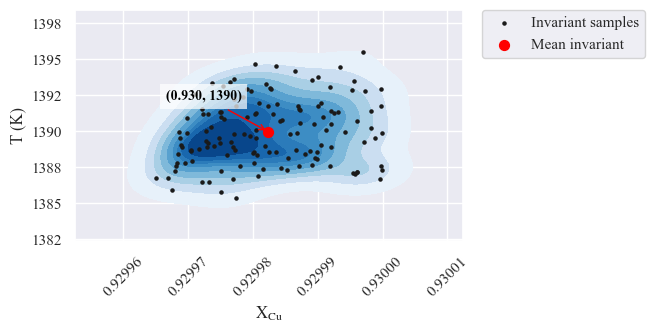

D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

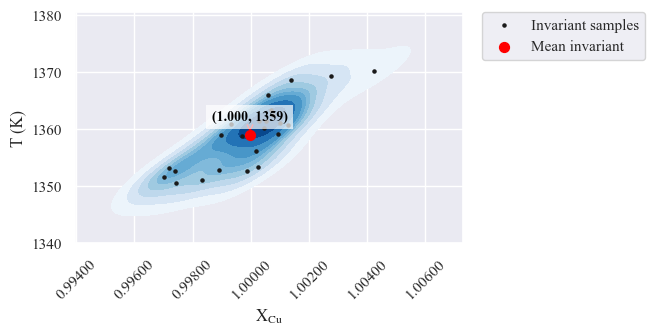

In [10]:
# 示例文献数据点
expt_points1 = [
    {'x': 0.914, 'y': 1385, 'label': 'Expt., Hashimoto et al.', 'color': 'blue', 'marker': 'X'},
    {'x': 0.920, 'y': 1385, 'label': 'Cal., Hasebe et al.', 'color': 'green', 'marker': 's'},
    {'x': 0.930, 'y': 1379, 'label': 'Cal., Gente et al.', 'color': 'purple', 'marker': 'D'},
    {'x': 0.912, 'y': 1381, 'label': 'Cal., Kubista et al.', 'color': 'orange', 'marker': 'v'},
    {'x': 0.918, 'y': 1376, 'label': 'Cal., Palumbo et al.', 'color': 'lime', 'marker': '^'},
    {'x': 0.909, 'y': 1386, 'label': 'Cal., Turchanin et al.', 'color': 'brown', 'marker': 'P'},
]

expt_points2 = [
]
# 将多个实验点传入为列表
expt_points_list = [expt_points1, expt_points2]
# 调用示例
# 假设 bndv 和 Tv 已经定义
points = np.zeros((len(Tv), 2))
points[:, 0] = bndv[:, 0]
points[:, 1] = Tv
plot_kde_clusters(points, num_clusters=2, 
                  xlabel=r'$\mathrm{X_{Cu}}$', 
                  ylabel='T (K)', 
                  save_name='newcocu_kde_result',
                  text_offset=(-0.00001, 2),
                  #expt_points_list=expt_points_list
                 )


D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future versi

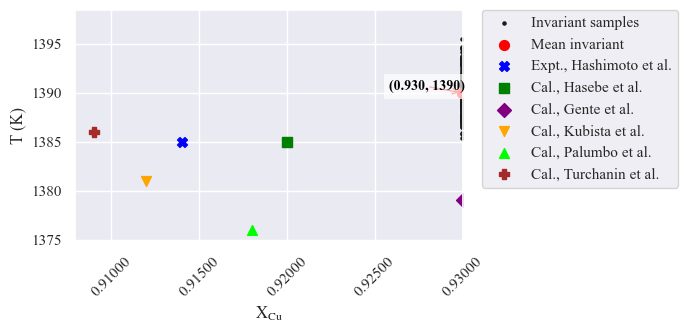

D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\ProgramData\anaconda3\envs\espei\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

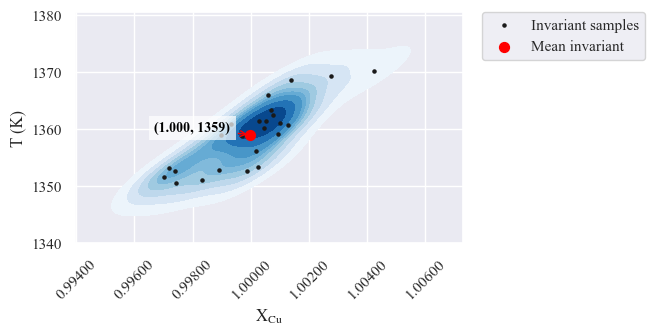

In [12]:
# 示例文献数据点
expt_points1 = [
    {'x': 0.914, 'y': 1385, 'label': 'Expt., Hashimoto et al.', 'color': 'blue', 'marker': 'X'},
    {'x': 0.920, 'y': 1385, 'label': 'Cal., Hasebe et al.', 'color': 'green', 'marker': 's'},
    {'x': 0.930, 'y': 1379, 'label': 'Cal., Gente et al.', 'color': 'purple', 'marker': 'D'},
    {'x': 0.912, 'y': 1381, 'label': 'Cal., Kubista et al.', 'color': 'orange', 'marker': 'v'},
    {'x': 0.918, 'y': 1376, 'label': 'Cal., Palumbo et al.', 'color': 'lime', 'marker': '^'},
    {'x': 0.909, 'y': 1386, 'label': 'Cal., Turchanin et al.', 'color': 'brown', 'marker': 'P'},
]

expt_points2 = [
]
# 将多个实验点传入为列表
expt_points_list = [expt_points1, expt_points2]
# 调用示例
# 假设 bndv 和 Tv 已经定义
points = np.zeros((len(Tv), 2))
points[:, 0] = bndv[:, 0]
points[:, 1] = Tv
plot_kde_clusters(points, num_clusters=2, 
                  xlabel=r'$\mathrm{X_{Cu}}$', 
                  ylabel='T (K)', 
                  save_name='new2cocu_kde_result',
                  text_offset=(-0.002, 0),
                  expt_points_list=expt_points_list
                 )
